In [1]:
import numpy as np
input = np.load("input_25_test.npy")
nsr = np.load("nsr_25_test.npy")
nsr_expanded = nsr[:, np.newaxis, :, :]
input_array = np.concatenate((input, nsr_expanded), axis=1)

In [2]:
input_array[:, 0, :, :] = np.nan_to_num(input_array[:, 0, :, :], nan=0.0)

In [3]:
import torch

input_data = torch.from_numpy(input_array)

mean = input_data.mean(dim=(0, 2, 3))
std = input_data.std(dim=(0, 2, 3))

# 由于均值和标准差是针对每个特征计算的，它们的形状应为 [7]
# 我们需要在时间和网格维度上扩展它们以用于广播
mean = mean.view(1, 8, 1, 1)
std = std.view(1, 8, 1, 1)

# 标准化数据
normalized_data = (input_data - mean) / std

In [4]:
normalized_data.shape

torch.Size([100, 8, 721, 1440])

In [5]:
import torch
from torch import nn
import numpy as np
from timm.models.layers import trunc_normal_, DropPath

from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d

In [6]:
import torch
from torch import nn
import numpy as np
from timm.models.layers import trunc_normal_, DropPath

from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d


class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor):
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x

        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Canglong(nn.Module):
    """
    Pangu A PyTorch impl of: `Pangu-Weather: A 3D High-Resolution Model for Fast and Accurate Global Weather Forecast`
    """

    def __init__(self, embed_dim=72, num_heads=(6, 12, 12, 6), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4),
            in_channels=4 + 3,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(13, 721, 1440),
            patch_dims=(2, 4, 4),
            in_channels=5,
            out_channels=embed_dim
        )

        self.patchembed_wlh = ImageToPatch3D(
            img_dims=(16, 721, 1440),
            patch_dims=(2, 4, 4),
            in_channels=8,
            out_channels=embed_dim
        )

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(8, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(8, 181, 360), output_resolution=(8, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(8, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(8, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (8, 91, 180), (8, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(8, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (8, 8), 2 * embed_dim, 4)
        self.patchrecovery3d = RecoveryImage3D((13, 721, 1440), (2, 8, 8), 2 * embed_dim, 5)
        self.patchrecovery3d_wlh = RecoveryImage3D((13, 721, 1440), (1, 8, 8), 2 * embed_dim, 1)

    def forward(self, upper_air):
        wlh_input = self.patchembed_wlh(upper_air)
        x = wlh_input

        B, C, Pl, Lat, Lon = x.shape
        x = x.reshape(B, C, -1).transpose(1, 2)

        x = self.layer1(x)

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)

        output_surface = output[:, :, 0, :, :]
        output_upper_air = output[:, :, 1:, :, :]

        output_surface = self.patchrecovery2d(output_surface)
        output_upper_air = self.patchrecovery3d(output_upper_air)
        output = self.patchrecovery3d_wlh(output)

        return output


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from random import randint

class WeatherDataset(Dataset):
    def __init__(self, input_data, mode='train'):
        self.input = input_data
        self.mode = mode

        if self.mode == 'train':
            self.input = self.input[:50]  
        elif self.mode == 'validation':
            self.input = self.input[-50:-25] 
        elif self.mode == 'test':
            self.input = self.input[-25:] 

        print(f"{self.mode} input shape: ", self.input.shape)

    def __len__(self):
        if self.mode == 'train':
            return 50 - 20  # 确保索引不会超出范围
        else:
            return 25 - 20

    def __getitem__(self, idx):
        upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, idx:idx + 16, :, :]
        target_surface = self.input[idx + 17: idx + 20, 0, :, :]
        return upper_input, target_surface

# 模型、优化器和设备定义
# model = Canglong()
# model = nn.DataParallel(model)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(DEVICE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Canglong()  # 实例化模型对象
if torch.cuda.device_count() > 1:  # 检查电脑是否有多块GPU
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)  # 将模型对象转变为多GPU并行运算的模型

model.to(device)  # 把并行的模型移动到GPU上


optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 创建数据集和数据加载器
train_dataset = WeatherDataset(normalized_data, mode='train')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

valid_dataset = WeatherDataset(normalized_data, mode='validation')
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

test_dataset = WeatherDataset(normalized_data, mode='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 打印可用GPU数量
print(f"Available GPUs: {torch.cuda.device_count()}")

def weighted_mse_loss(output, target, spatial_weights):
    """计算加权均方误差 (MSE)"""
    return torch.mean(spatial_weights * (output - target) ** 2)

def calc_correlation_penalty(output, target, lat_range, lon_range):
    """计算相关性惩罚项"""
    output_nino = output[:, lat_range, lon_range]
    target_nino = target[:, lat_range, lon_range]

    output_mean = torch.mean(output_nino, dim=[1, 2], keepdim=True)
    target_mean = torch.mean(target_nino, dim=[1, 2], keepdim=True)

    covariance = torch.mean((output_nino - output_mean) * (target_nino - target_mean), dim=[1, 2])
    output_std = torch.std(output_nino, dim=[1, 2], unbiased=False)
    target_std = torch.std(target_nino, dim=[1, 2], unbiased=False)

    corr_coef = covariance / (output_std * target_std)
    penalty = torch.sum(torch.clamp(0.5 - corr_coef, min=0.0)) / 3  # 正规化
    return penalty

def custom_loss_function(output, target, spatial_weights, time_weights):
    """自定义损失函数，组合加权MSE和相关性惩罚项"""
    weighted_mse = weighted_mse_loss(output * time_weights, target * time_weights, spatial_weights)
    corr_penalty = calc_correlation_penalty(output, target, slice(288, 336), slice(480, 640))
    return weighted_mse + corr_penalty

# 创建空间权重矩阵，除Nino3.4区域外，所有权重为1
spatial_weights = torch.ones((1, 721, 1440)).to(device)
spatial_weights[0, 0*4: 20*4, 20*4: 150*4] = 1

# 时间权重
time_weights = torch.tensor([1., 1.5, 2.]).view(3, 1, 1).to(device)




/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


train input shape:  torch.Size([50, 8, 721, 1440])
validation input shape:  torch.Size([25, 8, 721, 1440])
test input shape:  torch.Size([25, 8, 721, 1440])
Available GPUs: 1


In [8]:
# 开始训练
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for i, (upper_air, target_surface) in enumerate(train_loader):
        upper_air, target_surface = upper_air.to(device), target_surface.to(device)
        optimizer.zero_grad()  # 清除旧的梯度

        output_surface = model(upper_air)
        output_surface = output_surface[0, 0, :, :, :]
        target_surface = target_surface[0, :, :, :]

        loss = custom_loss_function(output_surface, target_surface, spatial_weights, time_weights)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 验证过程
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for j, (upper_air, target_surface) in enumerate(valid_loader):
            upper_air, target_surface = upper_air.to(device), target_surface.to(device)
            output_surface = model(upper_air)
            output_surface = output_surface[0, 0, :, :, :]
            target_surface = target_surface[0, :, :, :]

            loss = custom_loss_function(output_surface, target_surface, spatial_weights, time_weights)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

/tmp/ipykernel_1150/1872073056.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, idx:idx + 16, :, :]


Epoch 1/3, Train Loss: 77.669716, Validation Loss: 2.249841
Epoch 2/3, Train Loss: 63.792323, Validation Loss: 2.124619
Epoch 3/3, Train Loss: 57.201641, Validation Loss: 1.934844


In [153]:
# One months
tar_id = 17
month = 160 - tar_id + 1
from torch.utils.data import Dataset, DataLoader
class WeatherDatasetInfer(Dataset):
    def __init__(self, input_data, id=0, month=1):
        self.input = input_data
        self.t = month
        self.id = id

        
        self.input = self.input 
        print("input: ",self.input.shape)

    def __len__(self):
        return self.t
    

    def __getitem__(self, idx):
        upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, self.id + idx: self.id + idx + 16, :, :]
        target_surface = self.input[self.id + idx + 16, 0, :, :]
        return upper_input, target_surface

test_dataset = WeatherDatasetInfer(normalized_data, id= tar_id - 17, month=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

input:  torch.Size([160, 8, 721, 1440])


In [169]:
## lead 1
r2_list, rmse_list, lead_2 =  [], [], []
for i in range(144 - 1):
    normalized_data = normalized_data1

    normalized_data[i + 16, 0, :, :] = torch.tensor(lead_1[i])
    idi = 18 + i
    test_dataset1 = WeatherDatasetInfer(normalized_data, id= idi - 17, month=1)
    test_loader1 = DataLoader(test_dataset1, batch_size=1, shuffle=False)
    with torch.no_grad():
        the_model.eval()
        
        for step, (upper_air, target_surface) in enumerate(test_loader1):
            upper_air, target_surface = upper_air.to(DEVICE), target_surface.to(DEVICE)
            output = the_model(upper_air.cuda())
            with torch.no_grad():
    
                sst1 = output[0, 0, 0, :, :].cpu().detach().numpy() * std_all.numpy()[0, 0, 0, 0]
                sst2 = target_surface[0, :, :].cpu().detach().numpy() * std_all.numpy()[0, 0, 0, 0]
    
                sst1[ocean_mask] = None
                sst2[ocean_mask] = None
    
    
                rmse = np.sqrt(np.mean((sst1[~np.isnan(sst1)].flatten() - sst2[~np.isnan(sst2)].flatten())**2))
                r2 = np.corrcoef(sst1[~np.isnan(sst1)].flatten(), sst2[~np.isnan(sst2)].flatten())[0, 1]
                rmse_list.append(rmse)
                r2_list.append(r2)
                lead_2.append(output[0, 0, 0, :, :].cpu().detach().numpy())
    
                
                print(f"index {i + 18}, RMSE: {rmse}, r2: {r2}")

input:  torch.Size([160, 8, 721, 1440])


C:\Users\DELL\AppData\Local\Temp\ipykernel_40964\1805854815.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_input = torch.tensor(self.input).permute(1, 0, 2, 3)[:, self.id + idx: self.id + idx + 16, :, :]


index 18, RMSE: 1.2442911863327026, r2: 0.9942602635186462
input:  torch.Size([160, 8, 721, 1440])
index 19, RMSE: 2.1477622985839844, r2: 0.9831026676301502
input:  torch.Size([160, 8, 721, 1440])
index 20, RMSE: 2.723614454269409, r2: 0.9731434449095432
input:  torch.Size([160, 8, 721, 1440])
index 21, RMSE: 2.264105796813965, r2: 0.9814337746955355
input:  torch.Size([160, 8, 721, 1440])
index 22, RMSE: 1.2622374296188354, r2: 0.9941564341997325
input:  torch.Size([160, 8, 721, 1440])
index 23, RMSE: 1.3908368349075317, r2: 0.9936070439029275
input:  torch.Size([160, 8, 721, 1440])
index 24, RMSE: 2.3704917430877686, r2: 0.9807522801268389
input:  torch.Size([160, 8, 721, 1440])
index 25, RMSE: 2.3025989532470703, r2: 0.9809440670575843
input:  torch.Size([160, 8, 721, 1440])
index 26, RMSE: 1.7770969867706299, r2: 0.9883879579219481
input:  torch.Size([160, 8, 721, 1440])
index 27, RMSE: 1.4801204204559326, r2: 0.9928419714565585
input:  torch.Size([160, 8, 721, 1440])
index 28, RM

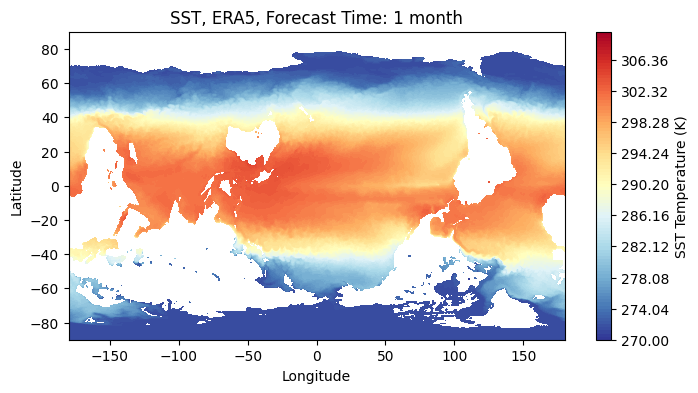

In [25]:
lons = np.linspace(-180, 180, 1440)
lats = np.linspace(-90, 90, 721)
lon, lat = np.meshgrid(lons, lats)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming 'data' is a 721x1440 matrix representing ERA5 lat/lon data
# Here I'll create a mock 'data' array as we do not have the actual data.
# The actual data should be loaded from the ERA5 dataset.


# Define the size of the figure
fig = plt.figure(figsize=(8, 4))

data = sst2+ mean_all.numpy()[0, 0, 0, 0]
# Plot the data
plt.contourf(lon, lat, data, levels=np.linspace(270, 310, num=100), cmap='RdYlBu_r')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('SST Temperature (K)')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SST, ERA5, Forecast Time: 1 month')
# Set the aspect of the plot to be equal

# Show the plot
plt.show()

In [22]:
import xarray as xr
lons = np.linspace(-180, 180, 1440)
lats = np.linspace(-90, 90, 721)
data1_rolled = np.roll(sst2, 1440 // 2, axis=1)
# Convert the numpy array to an xarray DataArray
data_xr = xr.DataArray(data1_rolled, coords=[('lat', lats), ('lon', lons)], dims=['lat', 'lon'])

In [23]:
from utils import plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(0, 310, num=90)
plot.one_map_flat(data_xr, ax, levels=levels, cmap="RdBu_r",  mask_ocean=False, add_coastlines=True, add_land=False,  colorbar=True, plotfunc="pcolormesh")
ax2 = fig.add_axes([0.93, 0.237, 0.15, 0.517])
plot.add_sta(ax2, data_xr, [-10,10], 'lat')


ImportError: DLL load failed while importing trace: 找不到指定的模块。

E:\OneDrive\Untitled Folder\python\utils\plot.py:1096: RuntimeWarning: Mean of empty slice
  MED = np.nanmean(da.values, axis=1)
D:\anaconda3\envs\torch\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
E:\OneDrive\Untitled Folder\python\utils\plot.py:1099: RuntimeWarning: divide by zero encountered in true_divide
  margin_of_error = 1.96 * (STD / np.sqrt(n))


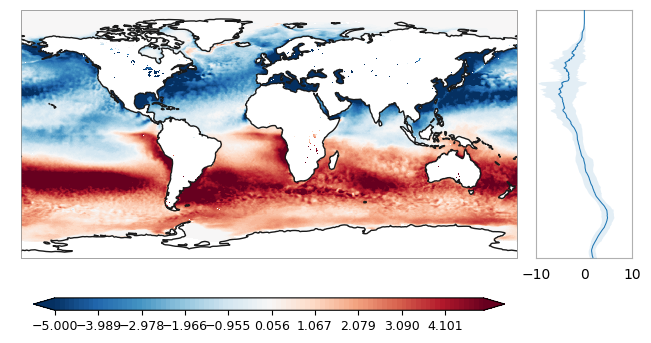

In [44]:
lons = np.linspace(-180, 180, 1440)
lats = np.linspace(-90, 90, 721)
data1_rolled = np.roll(data2, 1440 // 2, axis=1)
# Convert the numpy array to an xarray DataArray
data_xr = xr.DataArray(data1_rolled, coords=[('lat', lats), ('lon', lons)], dims=['lat', 'lon'])

fig = plt.figure()
proj = ccrs.PlateCarree() #ccrs.Robinson()ccrs.Mollweide()Mollweide()
ax = fig.add_subplot(111, projection=proj)
levels = np.linspace(-5, 5, num=90)
plot.one_map_flat(data_xr, ax, levels=levels, cmap="RdBu_r",  mask_ocean=False, add_coastlines=True, add_land=False,  colorbar=True, plotfunc="pcolormesh")
ax2 = fig.add_axes([0.93, 0.237, 0.15, 0.517])
plot.add_sta(ax2, data_xr, [-10,10], 'lat')
